## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Importacion del dataset de PRoperaty pre-Procesado anteriormente

In [2]:
dfprop=pd.read_csv(filepath_or_buffer='properati_buffered.csv',delimiter=',',index_col = 0 )

Se elimina las columnas 'cota_inf' y 'cota_sup'.
Adicionalmente se genera una columna unificando la ubicacion

In [3]:

dfprop.drop(['cota_inf','cota_sup'],axis=1,inplace=True)

In [4]:
# Generamos una key de zona
dfprop['district_name_key']=dfprop['country_name']+"-"+\
                            dfprop['state_name']+"-"+\
                            dfprop['district_name']


## Construccion de Dummies
-  Efectuar una inspeccion de los campos title y description para indicar la existencia de palabras claves 

In [5]:
def new_dummy_from_included_in_column(dfprop_aux,column,word):
    #dfprop_aux=dfprop
    #word='POZO'
    
    #Creamos la expresion regular ..."que el texto empiece con"... word 
    re_word="("+word+")"
    
    #Creamos la expresion regular
    re_search=dfprop[column].str.extract(re_word,expand=False)
    
    #re_search[((re_search!=-1)&(~(pd.isna(re_search))))].index
    #Creamos la columna dummy y seteamos todos los rows en 0
    dfprop_aux.loc[:,"dm_"+word]=0
    
    #Extraemos la lista de de indices donde la expresion se cumple
    prop_re_list =np.array(re_search[((re_search!=-1)&(~(pd.isna(re_search))))].index)
    
    #Actualizamos el valor de la columna Dummy a 1 en los casos dentro del indice enviado
    dfprop_aux.loc[dfprop_aux.index.isin(prop_re_list),"dm_"+word]=1
    
    print_dummy_count_rows(dfprop_aux,"dm_"+word)
    
    return dfprop_aux


def print_dummy_count_rows(dfprop_aux_p,word_p):
    print('Cantidad de rows con '+word_p+": ",dfprop_aux_p.loc[dfprop_aux_p[word_p]==1,'operation'].count())
    

In [6]:
def generate_dummies_per_location(dfprop_aux):
    total_district_name_key=len(dfprop_aux['district_name_key'].unique())
    i=1
    for district_name_key in dfprop_aux['district_name_key'].unique():
        #print(str(i)+" de "+str(total_district_name_key)+" - Generando Dummy para localidad: "+district_name_key)
        dfprop_aux=new_dummy_from_included_in_column(dfprop_aux,'district_name_key',district_name_key)
        i+=1
    return dfprop_aux

In [7]:
def plot_price_dispersion(dfprop_plot):
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.catplot(y="district_name_key", x="price_usd_per_m2", data=dfprop_plot,ax=ax);

In [8]:
def clean_outliers(dfprop_outlier):
    # Agrupamos por key y sacamos precio promedio
    dfprop_quartile=dfprop_outlier.groupby(by = ['district_name_key'])["price_usd_per_m2"].describe()
    dfprop_quartile['district_name_key']=dfprop_quartile.index
    dfprop_group_quartiles=dfprop_quartile[['25%','75%','district_name_key']]
    dfprop_group_quartiles['cota_inf']=dfprop_group_quartiles['25%']-((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
    dfprop_group_quartiles['cota_sup']=dfprop_group_quartiles['75%']+((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
    dfprop_group_quartiles=dfprop_group_quartiles[['cota_inf','cota_sup']]
    dfprop_group_quartiles
    dfprop_outlier=pd.merge(dfprop_outlier,dfprop_group_quartiles,how='left',on='district_name_key')
    dfprop_outlier=dfprop_outlier.loc[(dfprop_outlier['price_usd_per_m2']>dfprop_outlier['cota_inf'])&(dfprop_outlier['price_usd_per_m2']<dfprop_outlier['cota_sup'])]
    
    #Eliminamos las cotas
    dfprop_outlier.drop(['cota_inf','cota_sup'],axis=1,inplace=True)
    
    return dfprop_outlier

In [9]:
a=dfprop.columns
for i in a:
    print("'"+i+"',")

'operation',
'property_type',
'place_name',
'place_with_parent_names',
'country_name',
'state_name',
'geonames_id',
'lat-lon',
'lat',
'lon',
'price',
'currency',
'price_aprox_local_currency',
'price_aprox_usd',
'surface_total_in_m2',
'surface_covered_in_m2',
'price_usd_per_m2',
'price_per_m2',
'floor',
'rooms',
'expenses',
'properati_url',
'description',
'title',
'image_thumbnail',
'district_name',
'city_name',
'district_name_key',


In [10]:
def getFeaturers(dfprop_in):
    column_features=[
    'dm_house',
    'dm_apartment',   
    'dm_PH',
    'dm_d_sup_descubierta',
    'dm_d_cochera',
    'dm_d_servicios',
    'dm_d_amenities'
    ]

    #District_key
    for loc in dfprop['district_name_key'].unique():
        column_features.append('dm_'+loc) 

    return column_features

Se generan 3 Dummies para separar los tipos de propiedad 

In [11]:
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','PH')
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','apartment')
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','house')

Cantidad de rows con dm_PH:  5099
Cantidad de rows con dm_apartment:  62525
Cantidad de rows con dm_house:  31956


In [12]:
dfprop['state_name'].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Norte',
       'Santa Fe', 'Córdoba', 'Bs.As. G.B.A. Zona Oeste', 'Misiones',
       'Entre Ríos', 'Buenos Aires Interior', 'Neuquén', 'San Luis',
       'Río Negro', 'Salta', 'Mendoza', 'Tucumán', 'Corrientes', 'Chubut'],
      dtype=object)

In [13]:
dfprop['description']=dfprop['description'].str.lower()

dfprop=new_dummy_from_included_in_column(dfprop,'description','inmomap')
dfprop=dfprop.loc[dfprop['dm_inmomap']==0]

dfprop=new_dummy_from_included_in_column(dfprop,'description','construccion')
dfprop=dfprop.loc[dfprop['dm_construccion']==0]

dfprop=new_dummy_from_included_in_column(dfprop,'description','obra')
dfprop=dfprop.loc[dfprop['dm_obra']==0]

Cantidad de rows con dm_inmomap:  2532
Cantidad de rows con dm_construccion:  1625
Cantidad de rows con dm_obra:  3569


In [14]:
dfprop=generate_dummies_per_location(dfprop)

Cantidad de rows con dm_Argentina-Capital Federal-Mataderos:  349
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Sur-La Plata:  2602
Cantidad de rows con dm_Argentina-Capital Federal-Liniers:  308
Cantidad de rows con dm_Argentina-Buenos Aires Costa Atlántica-Mar del Plata:  6732
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-Vicente López:  3206
Cantidad de rows con dm_Argentina-Capital Federal-Belgrano:  2358
Cantidad de rows con dm_Argentina-Santa Fe-Rosario:  6947
Cantidad de rows con dm_Argentina-Córdoba-Córdoba:  5477
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-San Miguel:  1119
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-San Isidro:  2709
Cantidad de rows con dm_Argentina-Capital Federal-Palermo:  3140
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-Tigre:  7950
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Oeste-General Rodríguez:  126
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-Pilar:  2811
Cantid

Cantidad de rows con dm_Argentina-Buenos Aires Interior-Tandil:  70
Cantidad de rows con dm_Argentina-Mendoza-San Rafael:  71
Cantidad de rows con dm_Argentina-Buenos Aires Interior-San Pedro:  6
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Sur-Presidente Perón:  93
Cantidad de rows con dm_Argentina-Buenos Aires Costa Atlántica-Mar Azul:  29
Cantidad de rows con dm_Argentina-San Luis-San Luis:  42
Cantidad de rows con dm_Argentina-Buenos Aires Costa Atlántica-Valeria del Mar:  50
Cantidad de rows con dm_Argentina-Capital Federal-Pompeya:  40
Cantidad de rows con dm_Argentina-Capital Federal-Villa General Mitre:  42
Cantidad de rows con dm_Argentina-Córdoba-Río Cuarto:  50
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Sur-San Vicente:  109
Cantidad de rows con dm_Argentina-Buenos Aires Interior-San Miguel del Monte:  13
Cantidad de rows con dm_Argentina-Neuquén-Lácar:  10
Cantidad de rows con dm_Argentina-Neuquén-Confluencia:  102
Cantidad de rows con dm_Argentina-Buenos 

In [19]:
dfprop.shape

(91854, 193)

## Analisis de Outliers

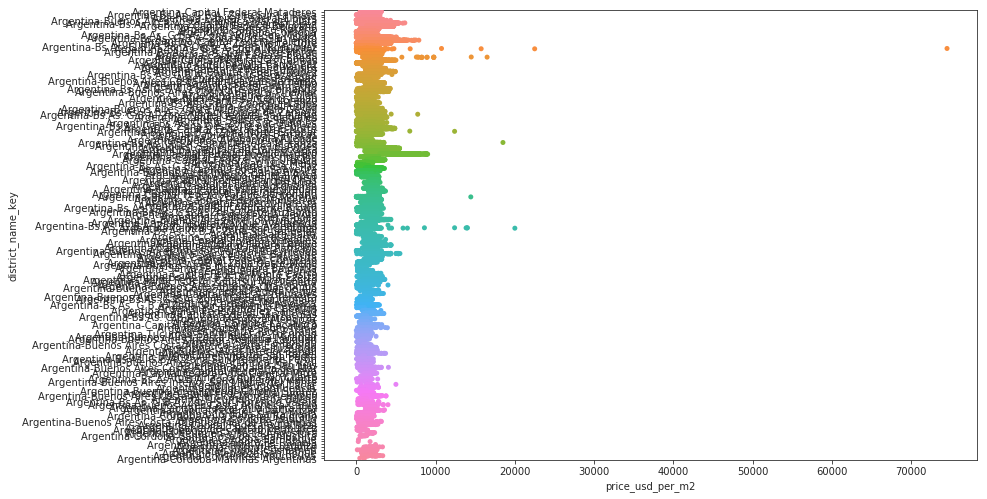

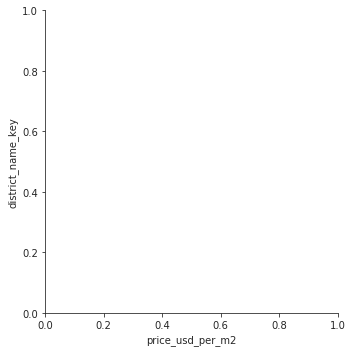

In [20]:
plot_price_dispersion(dfprop)

Consideramos un precio mayor a 8000 USD_per_m2 un valor incorrecto

In [21]:
#Capital Federal
dfprop=dfprop.loc[dfprop['price_usd_per_m2']<8000]
dfprop.shape

#dfprop=dfprop.loc[dfprop['price_usd_per_m2']>1000]

(91809, 193)

Limpiamos outliers

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


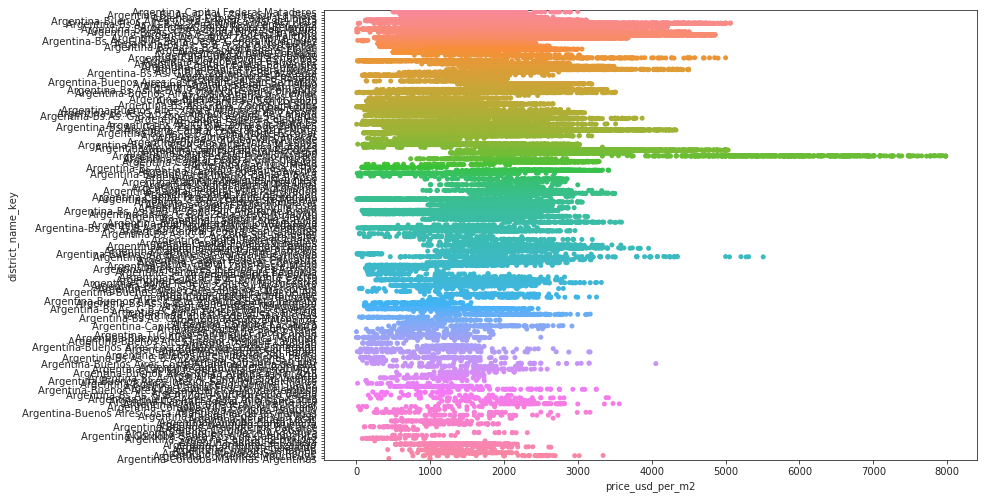

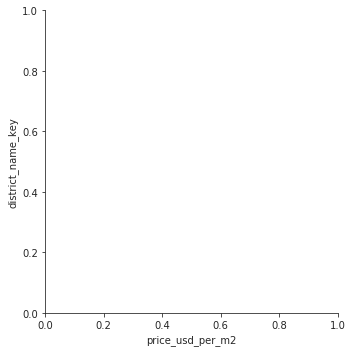

In [22]:
dfprop=clean_outliers(dfprop)
plot_price_dispersion(dfprop)

In [23]:
dfprop['description']=dfprop['description'].str.lower()

dfprop=new_dummy_from_included_in_column(dfprop,'description','planta alta')
dfprop=new_dummy_from_included_in_column(dfprop,'description','terraza')
dfprop=new_dummy_from_included_in_column(dfprop,'description','azotea')
dfprop=new_dummy_from_included_in_column(dfprop,'description','balcon')
dfprop=new_dummy_from_included_in_column(dfprop,'description','patio')


dfprop=new_dummy_from_included_in_column(dfprop,'description','cochera')
dfprop=new_dummy_from_included_in_column(dfprop,'description','cocheras')
dfprop=new_dummy_from_included_in_column(dfprop,'description','guardacoche')
dfprop=new_dummy_from_included_in_column(dfprop,'description','guarda coche')


dfprop=new_dummy_from_included_in_column(dfprop,'description','seguridad')
dfprop=new_dummy_from_included_in_column(dfprop,'description','vigilancia')
dfprop=new_dummy_from_included_in_column(dfprop,'description','caldera')
dfprop=new_dummy_from_included_in_column(dfprop,'description','calefaccion')
dfprop=new_dummy_from_included_in_column(dfprop,'description','central')


dfprop=new_dummy_from_included_in_column(dfprop,'description','pileta')
dfprop=new_dummy_from_included_in_column(dfprop,'description','parrilla')
dfprop=new_dummy_from_included_in_column(dfprop,'description','quincho')
dfprop=new_dummy_from_included_in_column(dfprop,'description','sum')
dfprop=new_dummy_from_included_in_column(dfprop,'description','amenities')
dfprop=new_dummy_from_included_in_column(dfprop,'description','gimnasio')

dfprop.shape

Cantidad de rows con dm_planta alta:  9511
Cantidad de rows con dm_terraza:  20637
Cantidad de rows con dm_azotea:  687
Cantidad de rows con dm_balcon:  12341
Cantidad de rows con dm_patio:  15077
Cantidad de rows con dm_cochera:  31781
Cantidad de rows con dm_cocheras:  11333
Cantidad de rows con dm_guardacoche:  578
Cantidad de rows con dm_guarda coche:  451
Cantidad de rows con dm_seguridad:  8154
Cantidad de rows con dm_vigilancia:  1997
Cantidad de rows con dm_caldera:  4430
Cantidad de rows con dm_calefaccion:  3021
Cantidad de rows con dm_central:  8390
Cantidad de rows con dm_pileta:  14229
Cantidad de rows con dm_parrilla:  26339
Cantidad de rows con dm_quincho:  9503
Cantidad de rows con dm_sum:  10574
Cantidad de rows con dm_amenities:  7794
Cantidad de rows con dm_gimnasio:  5277


(87737, 213)

In [24]:
condicion_sup_descubierta=((dfprop['dm_planta alta']==1)|\
                     (dfprop['dm_terraza']==1)|\
                     (dfprop['dm_azotea']==1)|\
                     (dfprop['dm_balcon']==1)|\
                     (dfprop['dm_patio']==1))

dfprop['dm_d_sup_descubierta']=0
dfprop.loc[condicion_sup_descubierta,'dm_d_sup_descubierta']=1

condicion_cochera=((dfprop['dm_cochera']==1)|\
                     (dfprop['dm_cocheras']==1)|\
                     (dfprop['dm_guarda coche']==1)|\
                     (dfprop['dm_guardacoche']==1))

dfprop.loc[condicion_cochera,'dm_d_cochera']=1
dfprop.loc[~condicion_cochera,'dm_d_cochera']=0

condicion_servicios=((dfprop['dm_seguridad']==1)|\
                     (dfprop['dm_vigilancia']==1)|\
                     (dfprop['dm_caldera']==1)|\
                     (dfprop['dm_central']==1)|\
                     (dfprop['dm_calefaccion']==1))

dfprop.loc[condicion_servicios,'dm_d_servicios']=1
dfprop.loc[~condicion_servicios,'dm_d_servicios']=0

condicion_amenities=((dfprop['dm_pileta']==1)|\
                     (dfprop['dm_parrilla']==1)|\
                     (dfprop['dm_quincho']==1)|\
                     (dfprop['dm_sum']==1)|\
                     (dfprop['dm_amenities']==1)|\
                     (dfprop['dm_gimnasio']==1))
 
dfprop.loc[condicion_amenities,'dm_d_amenities']=1
dfprop.loc[~condicion_amenities,'dm_d_amenities']=0


dfprop.drop(['dm_planta alta',
    'dm_terraza',
    'dm_azotea',
    'dm_balcon',
    'dm_patio', 
    'dm_cochera',
    'dm_cocheras',
    'dm_guarda coche',
    'dm_guardacoche',
    'dm_seguridad',
    'dm_vigilancia', 
    'dm_caldera',   
    'dm_calefaccion',
    'dm_central', 
    'dm_pileta', 
    'dm_parrilla',
    'dm_quincho', 
    'dm_sum',  
    'dm_amenities', 
    'dm_gimnasio',],axis=1,inplace=True)

In [25]:
dfprop_targets=dfprop.loc[:,'price_usd_per_m2']

dfprop_features= dfprop.loc[:,getFeaturers(dfprop)]

In [26]:
dfprop_features.columns

Index(['dm_house', 'dm_apartment', 'dm_PH', 'dm_d_sup_descubierta',
       'dm_d_cochera', 'dm_d_servicios', 'dm_d_amenities',
       'dm_Argentina-Capital Federal-Mataderos',
       'dm_Argentina-Bs.As. G.B.A. Zona Sur-La Plata',
       'dm_Argentina-Capital Federal-Liniers',
       ...
       'dm_Argentina-Neuquén-Villa La Angostura',
       'dm_Argentina-Córdoba-Santa Rosa de Calamuchita',
       'dm_Argentina-Santa Fe-Capitán Bermúdez',
       'dm_Argentina-Santa Fe-Rafaela', 'dm_Argentina-Corrientes-Ituzaingó',
       'dm_Argentina-Chubut-Escalante', 'dm_Argentina-Chubut-Cushamen',
       'dm_Argentina-Mendoza-San Roque', 'dm_Argentina-Corrientes-Mburucuyá',
       'dm_Argentina-Córdoba-Malvinas Argentinas'],
      dtype='object', length=163)

In [27]:
#SEGUNDA SEPARACION TRAIN-TEST SPLIT
#X = PolynomialFeatures(2,include_bias=False,interaction_only=False).fit_transform(X)
print('Train-Test')
X_train, X_test, y_train, y_test = train_test_split(dfprop_features,dfprop_targets, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Train-Test
(61415, 163) (61415,)
(26322, 163) (26322,)


## Linear Regression

In [28]:
def plot_coef(name,coef,coef_color,r2):
    plt.plot(coef, color=coef_color, linewidth=2,label=name+' coefficients')  
    plt.legend(loc='best')
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width to 12 and height to 9
    fig_size[0] = 10
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    plt.title(name+" R^2: %.4f"% r2)
    plt.show()

In [29]:
def Linear_Regression(X_train,y_train):
    '''ordinaria'''
    # en K partes para realizar la validación cruzada
    kf = KFold(n_splits=10, shuffle=True)

    # Instanciamos los modelos
    lm = LinearRegression()

    # Hacemos los fits respectivos
    lm.fit(X_train, y_train)

    # Calculamos el R2
    print(" Score Train Lineal: %.4f\n" % lm.score(X_train, y_train))

    # Calculamos el RMSE
    y_pred_tr_lm = lm.predict(X_train)

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

    print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm))
    plot_coef('Linear Reg',lm.coef_,'blue',  lm.score(X_train, y_train))
    return lm

## Ridge

In [30]:
def Ridge_Regression(X_train,y_train):
    '''ridge'''
    al_ridge = np.linspace(0.02, 1.5, 200)
    kf = KFold(n_splits=10, shuffle=True)
    # Instanciamos los modelos

    lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)

    # Hacemos los fits respectivos
    lm_ridge_cv.fit(X_train, y_train)

    print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n')
    # Calculamos el R2

    print("Score Train Ridge : %.4f\n" % lm_ridge_cv.score(X_train, y_train))

    # Calculamos el RMSE

    y_pred_tr_ridge = lm_ridge_cv.predict(X_train)

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

    print("Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge))
    
    plot_coef('Ridge',lm_ridge_cv.coef_,'red',  lm_ridge_cv.score(X_train, y_train))
    return lm_ridge_cv

## LASSO

In [31]:
def Lasso_Regression(X_train,y_train):
    al_lasso = np.linspace(0.001, 1, 500)
    kf = KFold(n_splits=10, shuffle=True, random_state=12)
    al_lasso
    # Instanciamos los modelos

    lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

    # Hacemos los fits respectivos
    lm_lasso_cv.fit(X_train, y_train)

    print('Alpha LASSO:',lm_lasso_cv.alpha_,'\n')
    # Calculamos el R2
    print("Score Train Lasso : %.4f\n" %  lm_lasso_cv.score(X_train, y_train))

    # Calculamos el RMSE

    y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

    print("Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))
    
    plot_coef('Lasso',lm_lasso_cv.coef_,'green',  lm_lasso_cv.score(X_train, y_train))
    return lm_lasso_cv

## Test All Models

 Score Train Lineal: 0.6737

 Train RMSE lineal   : 486.11 



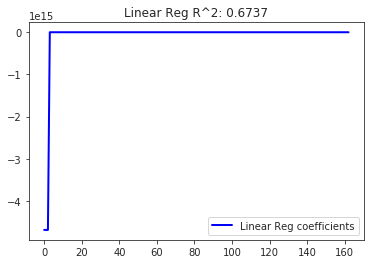

Alpha Ridge: 0.7190954773869347 

Score Train Ridge : 0.6737

Train RMSE Ridge    : 486.11 



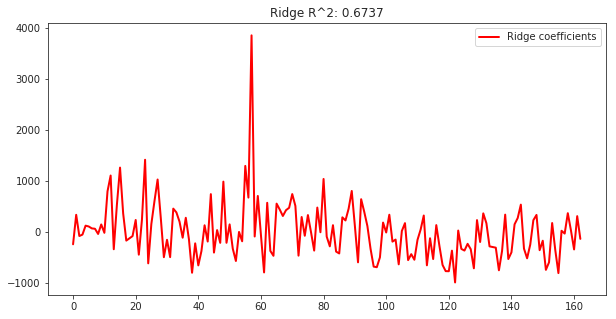

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Alpha LASSO: 0.001 

Score Train Lasso : 0.6737

Train RMSE Lasso    : 486.10 



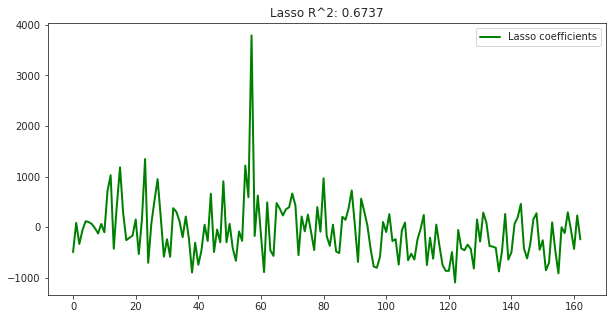

In [32]:
model_lm=Linear_Regression(X_train,y_train)
model_ridge=Ridge_Regression(X_train,y_train)
model_lasso=Lasso_Regression(X_train,y_train)

In [33]:
import pickle
with open('ridge.pkl', 'wb') as f:
    pickle.dump({'model':model_ridge}, f)
with open('linear.pkl', 'wb') as f:
    pickle.dump({'model':model_lm}, f)
with open('lasso.pkl', 'wb') as f:
    pickle.dump({'model':model_lasso}, f)

In [34]:
"""with open('ridge.pkl', 'wb') as fp:
    model = pickle.load(fp)

ridge = model['model']"""

"with open('ridge.pkl', 'wb') as fp:\n    model = pickle.load(fp)\n\nridge = model['model']"

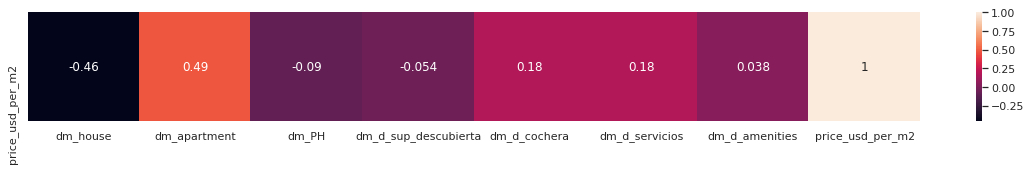

In [35]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,2)})
sns.heatmap(pd.concat([dfprop_features.loc[:,  ['dm_house', 'dm_apartment',   
    'dm_PH','dm_d_sup_descubierta',
    'dm_d_cochera',
    'dm_d_servicios',
    'dm_d_amenities']], pd.DataFrame(dfprop_targets, columns=['price_usd_per_m2'])], axis=1).corr().iloc[[-1]], annot=True);

 Score Train Lineal: 0.6726

 Train RMSE lineal   : 484.65 



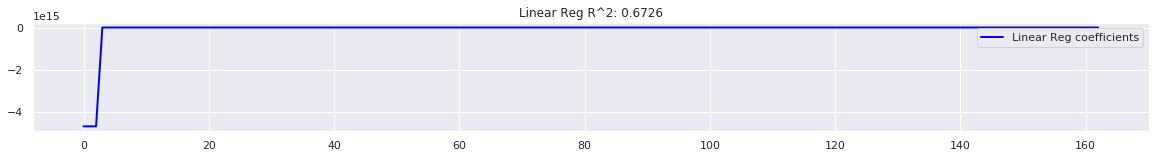

In [36]:
#Reg lineal
print(" Score Train Lineal: %.4f\n" % model_lm.score(X_test, y_test))

# Calculamos el RMSE
y_pred_test_lm = model_lm.predict(X_test)

rmse = lambda y_test, y_pred_test_lm: np.sqrt(mean_squared_error(y_test, y_pred_test_lm))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_test,y_pred_test_lm))
plot_coef('Linear Reg',model_lm.coef_,'blue',  model_lm.score(X_test, y_test))



 Score Train Lineal: 0.6725

 Train RMSE lineal   : 484.68 



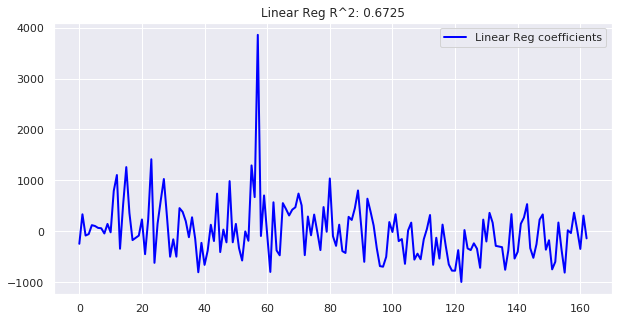

In [37]:
#Ridge
print(" Score Train Lineal: %.4f\n" % model_ridge.score(X_test, y_test))

# Calculamos el RMSE
y_pred_test_ridge = model_ridge.predict(X_test)

rmse = lambda y_test, y_pred_test_ridge: np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_test,y_pred_test_ridge))
plot_coef('Linear Reg',model_ridge.coef_,'blue',  model_ridge.score(X_test, y_test))



 Score Train Lineal: 0.6725

 Train RMSE lineal   : 484.69 



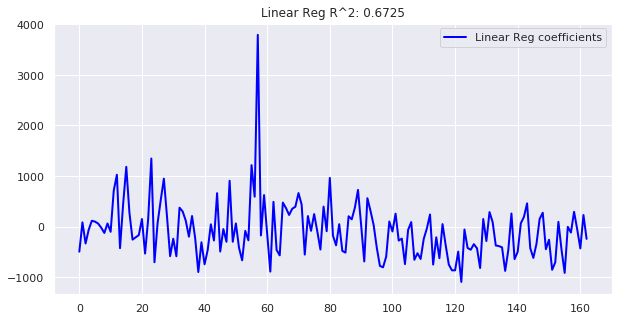

In [38]:
#Lasso
print(" Score Train Lineal: %.4f\n" % model_lasso.score(X_test, y_test))

# Calculamos el RMSE
y_pred_test_lasso = model_lasso.predict(X_test)

rmse = lambda y_test, y_pred_test_lasso: np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_test,y_pred_test_lasso))
plot_coef('Linear Reg',model_lasso.coef_,'blue',  model_lasso.score(X_test, y_test))

In [40]:
final_model = model_lasso.fit(dfprop_features, dfprop_targets)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [57]:
#Exportamos el modelo final
with open('final_model.pkl', 'wb') as f:
    pickle.dump({'model':final_model}, f)

#pickle_in = open("final_model.pkl","rb")
#model = pickle.load(pickle_in)


#ridge = model['model']

 Score Lasso: 0.6736

 RMSE    : 485.51 



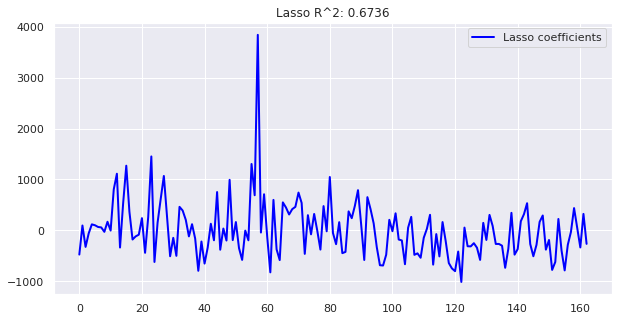

In [58]:
#Lasso Final
print(" Score Lasso: %.4f\n" % model_lasso.score(dfprop_features, dfprop_targets))

# Calculamos el RMSE
y_pred_lasso = model_lasso.predict(dfprop_features)

rmse = lambda y, y_pred_lasso: np.sqrt(mean_squared_error(dfprop_targets, y_pred_lasso))

print(" RMSE    : %.2f \n" % rmse(dfprop_targets,y_pred_lasso))
plot_coef('Lasso',model_lasso.coef_,'blue',  model_lasso.score(dfprop_features, dfprop_targets))

In [ ]:
"""# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.xlabel("Predicciones ")
plt.ylabel("Valores reales")

sns.set_style('ticks')

plt.scatter(y_pred_tr_lm_a,y_test, s=30, c='r', marker='+', zorder=10)
plt.show()"""

In [60]:
#calculamos precios usando el precio usd/m2, que es el que usamos en nuestro modelo
price_calc = []
for x in range(len(dfprop.index)):
    price_calc.append(dfprop.iloc[x].loc['surface_total_in_m2']*dfprop.iloc[x].loc['price_usd_per_m2'])
dfprop['price_calc'] = price_calc

In [61]:
dfportafolio = dfprop.sample(n = 100, random_state=1)
dfportafolio['price_calc'].sum()

22235086.58766866

In [62]:
y_portafolio=dfportafolio.loc[:,'price_usd_per_m2']

x_portafolio= dfportafolio.loc[:,getFeaturers(dfportafolio)]

In [63]:
y_portafolio_predict = final_model.predict(x_portafolio)

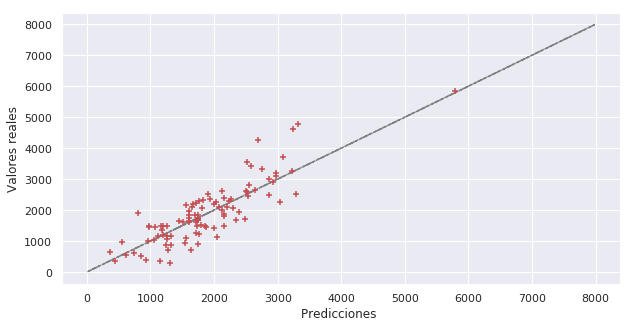

In [66]:
# Graficamos los resultados
plt.plot(dfprop_targets,dfprop_targets, '-.', c='grey')
plt.xlabel("Predicciones ")
plt.ylabel("Valores reales")

sns.set_style('ticks')

plt.scatter(y_portafolio_predict,y_portafolio, s=30, c='r', marker='+', zorder=10)
plt.show()

In [68]:
dfportafolio['price_usd_per_m2_predicted'] = y_portafolio_predict
price_predicted = []
for x in range(len(dfportafolio.index)):
    price_predicted.append(dfportafolio.iloc[x].loc['surface_total_in_m2']*dfportafolio.iloc[x].loc['price_usd_per_m2_predicted'])
dfportafolio['price_predicted'] = price_predicted
print("La diferencia entre el valor de mercado de nuestro portafolio y el valor modelado es de: %.2f \n" % (dfportafolio['price_calc'].sum() - dfportafolio['price_predicted'].sum()))

La diferencia entre el valor de mercado de nuestro portafolio y el valor modelado es de: -1649982.33 

